### About the dataset

The dataset contains the following information of 30000 customers:

DEFAULT - Default payment next month (Yes=1, No=0), now has been inverted

LIMIT_BAL - Amount of the given credit (INR)

SEX - Gender (1 = male; 2 = female)

EDUCATION - Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

MARRIAGE - (1 = married; 2 = single; 3 = others)

AGE - (year)

PAY - History of repayment status

- PAY1 = the repayment status in September 2005
- PAY2 = the repayment status in August 2005 ....
- PAY6 = the repayment status in April 2005
- The measurement scale for the repayment status is:

  i. - 1 = pay duly <br>
  ii. 1 = payment delay for one month<br>
  iii. 2 = payment delay for two months <br>
  iv. 8 = payment delay for eight months<br>
  v. 9 = payment delay for nine months and above <br>

BILL_AMT- Amount of bill statement (INR)

- BILL_AMT1 = amount of bill statement in September 2005
- BILL_AMT2 = amount of bill statement in August 2005....
- BILL_AMT6 = amount of bill statement in April 2005

PAY_AMT - Amount of previous payment (INR)

- PAY_AMT1 = amount paid in September 2005
- PAY_AMT2 = amount paid in August 2005....
- PAY_AMT6 = amount paid in April 2005

### Additional information

- The difference between the bill amount and the past pay for a month will give an indication of the pending amount for each month and can be used as an additional X variable

- The average / sum of bill amount can be used as an additional X variable which will give an indication on the customer value.


In [2]:
# NOW WE ARE TRYING TO PREDICT WHETHER A CUSTOMER WOULD MAKE THE PAYMENT IN TIME OR NOT, 

# 1 MEANS THAT THE CUSTOMER MAKES THE PAYMENT ON TIME, 
# 0 MEANS THAT THE CUSTOMER DOESN'T MAKE THE PAYMENT ON TIME

#### Precision:

Proportion of positive predictions that are actually positive.
High precision is important when the cost of false positives (predicting a customer will pay on time when they won't) is high.
For example, if false positives lead to increased risk of default, then precision is crucial.
#### Recall:

Measures the proportion of actual positive cases that are correctly identified.
High recall is important when the cost of false negatives (predicting a customer won't pay on time when they will) is high.
For instance, if false negatives lead to lost revenue or missed opportunities, then recall is crucial.
#### F1-Score:

The harmonic mean of precision and recall.
It provides a balanced measure of both precision and recall.
A high F1-score indicates a good balance between precision and recall.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    ConfusionMatrixDisplay,

)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [4]:
df = pd.read_csv("res/UCI_Credit_Card.csv")
df.rename(
    columns={"PAY_0": "PAY_1", "default.payment.next.month": "def_pay"}, inplace=True
)
df["def_pay"] = df["def_pay"].apply(lambda x: 1 if x == 0 else 0)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1


In [5]:
# replacing negative bill amounts with 0, since they don't mean anything
bill_amt_columns = [
    "BILL_AMT1",
    "BILL_AMT2",
    "BILL_AMT3",
    "BILL_AMT4",
    "BILL_AMT5",
    "BILL_AMT6",
]

for col in bill_amt_columns:
    df[col] = df[col].apply(lambda x: max(x, 0))

In [6]:
df[df["ID"].duplicated()]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay


In [7]:
df.drop(columns=["ID", "SEX","MARRIAGE"], axis=1, inplace=True)
data = df.copy()

In [8]:
df.shape

(30000, 22)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   EDUCATION  30000 non-null  int64  
 2   AGE        30000 non-null  int64  
 3   PAY_1      30000 non-null  int64  
 4   PAY_2      30000 non-null  int64  
 5   PAY_3      30000 non-null  int64  
 6   PAY_4      30000 non-null  int64  
 7   PAY_5      30000 non-null  int64  
 8   PAY_6      30000 non-null  int64  
 9   BILL_AMT1  30000 non-null  float64
 10  BILL_AMT2  30000 non-null  float64
 11  BILL_AMT3  30000 non-null  float64
 12  BILL_AMT4  30000 non-null  float64
 13  BILL_AMT5  30000 non-null  float64
 14  BILL_AMT6  30000 non-null  float64
 15  PAY_AMT1   30000 non-null  float64
 16  PAY_AMT2   30000 non-null  float64
 17  PAY_AMT3   30000 non-null  float64
 18  PAY_AMT4   30000 non-null  float64
 19  PAY_AMT5   30000 non-null  float64
 20  PAY_AM

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0
PAY_6,30000.0,-0.291100,1.149988,-2.0,-1.00,0.0,0.00,8.0
BILL_AMT1,30000.0,51246.041900,73608.029080,0.0,3558.75,22381.5,67091.00,964511.0


In [11]:
df.isnull().sum().sum()

0

In [12]:
cols = df.columns.to_list()
cols

['LIMIT_BAL',
 'EDUCATION',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'def_pay']

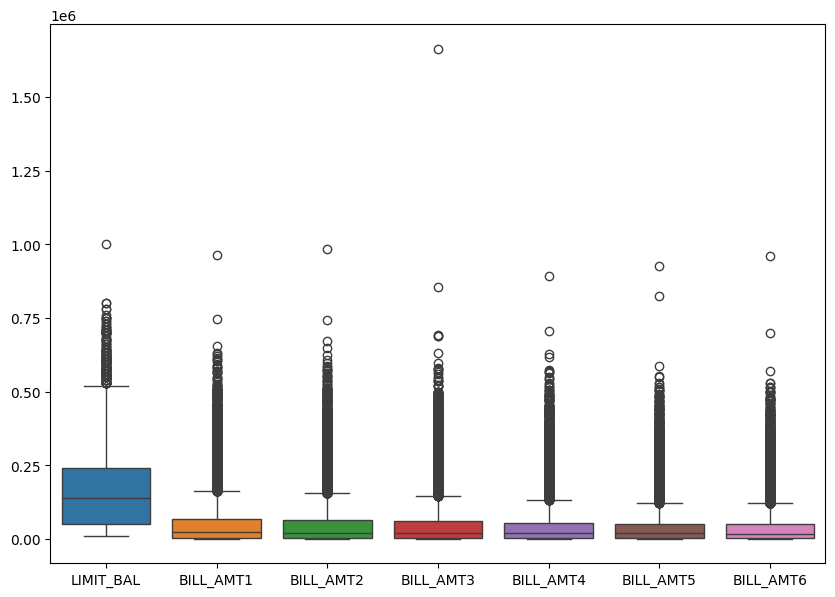

In [13]:
# boxplot for bill_Amt and limit_bal

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df[
        [
            "LIMIT_BAL",
            "BILL_AMT1",
            "BILL_AMT2",
            "BILL_AMT3",
            "BILL_AMT4",
            "BILL_AMT5",
            "BILL_AMT6",
        ]
    ]
)

plt.show()

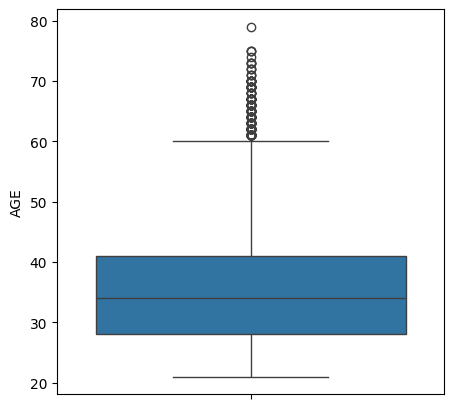

In [14]:
# Boxplot for column 'AGE'
plt.figure(figsize=(5, 5))
sns.boxplot(data=df["AGE"])
plt.show()

In [15]:
# Outliers on numerical Columns
num_var = df.select_dtypes(exclude="object")
for i in num_var:
    q1 = df[i].quantile(0.25)
    q3 = df[i].quantile(0.75)

    IQR = q3 - q1
    UL = q3 + 1.5 * IQR
    LL = q1 - 1.5 * IQR

    print("IQR of", i, "= ", IQR)
    print("UL of", i, "= ", UL)
    print("LL of", i, "= ", LL)
    print(
        f"Number of Outliers in {i} = {(df.shape[0] - df[(df[i] < UL) & (df[i] > LL)].shape[0])}"
    )
    print(" ")

IQR of LIMIT_BAL =  190000.0
UL of LIMIT_BAL =  525000.0
LL of LIMIT_BAL =  -235000.0
Number of Outliers in LIMIT_BAL = 167
 
IQR of EDUCATION =  1.0
UL of EDUCATION =  3.5
LL of EDUCATION =  -0.5
Number of Outliers in EDUCATION = 454
 
IQR of AGE =  13.0
UL of AGE =  60.5
LL of AGE =  8.5
Number of Outliers in AGE = 272
 
IQR of PAY_1 =  1.0
UL of PAY_1 =  1.5
LL of PAY_1 =  -2.5
Number of Outliers in PAY_1 = 3130
 
IQR of PAY_2 =  1.0
UL of PAY_2 =  1.5
LL of PAY_2 =  -2.5
Number of Outliers in PAY_2 = 4410
 
IQR of PAY_3 =  1.0
UL of PAY_3 =  1.5
LL of PAY_3 =  -2.5
Number of Outliers in PAY_3 = 4209
 
IQR of PAY_4 =  1.0
UL of PAY_4 =  1.5
LL of PAY_4 =  -2.5
Number of Outliers in PAY_4 = 3508
 
IQR of PAY_5 =  1.0
UL of PAY_5 =  1.5
LL of PAY_5 =  -2.5
Number of Outliers in PAY_5 = 2968
 
IQR of PAY_6 =  1.0
UL of PAY_6 =  1.5
LL of PAY_6 =  -2.5
Number of Outliers in PAY_6 = 3079
 
IQR of BILL_AMT1 =  63532.25
UL of BILL_AMT1 =  162389.375
LL of BILL_AMT1 =  -91739.625
Number of 

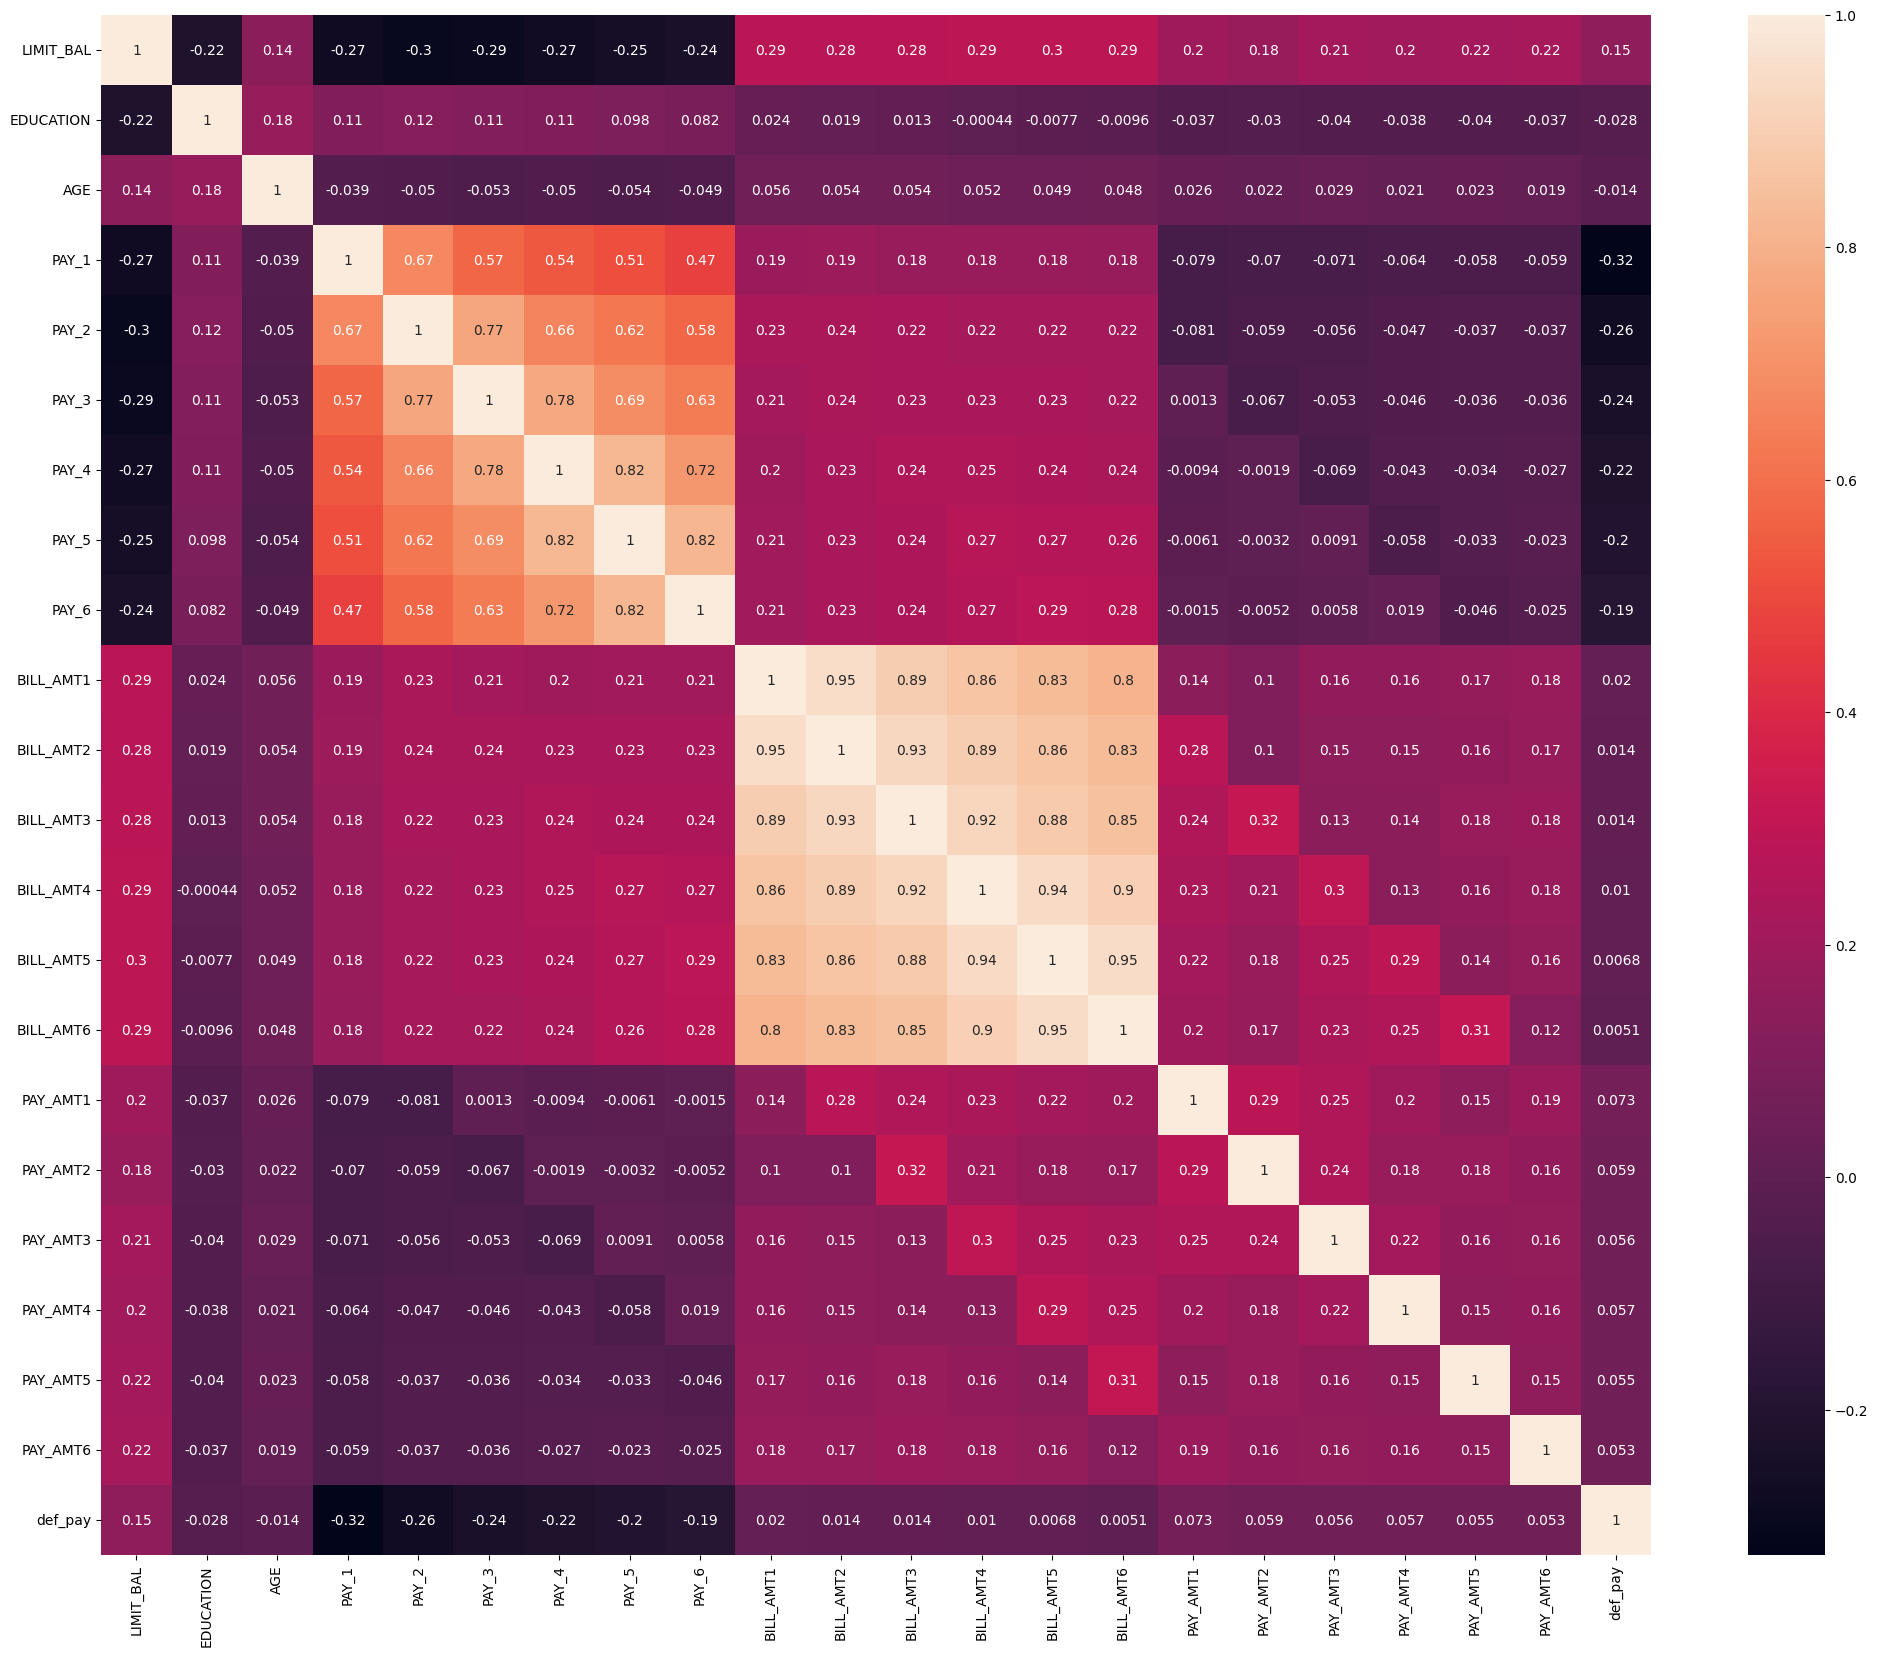

In [16]:
# Checking correlation
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [17]:
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,20000.0,2,24,2,2,-1,-1,-2,-2,3913.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0
1,120000.0,2,26,-1,2,0,0,0,2,2682.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0
2,90000.0,2,34,0,0,0,0,0,0,29239.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1
3,50000.0,2,37,0,0,0,0,0,0,46990.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1
4,50000.0,2,57,-1,0,-1,0,0,0,8617.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1


def_pay
1    77.88
0    22.12
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

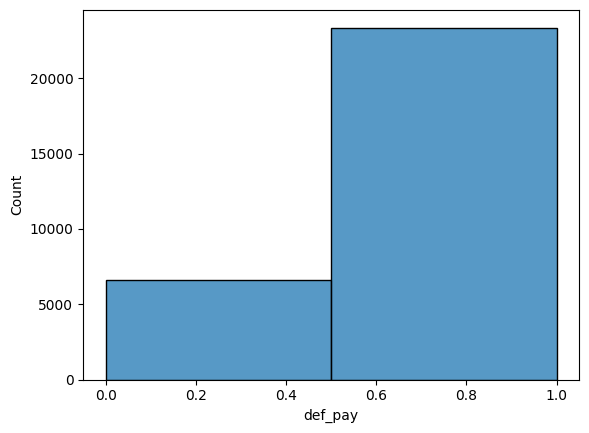

In [18]:
print(
    (
        df["def_pay"].value_counts()
        / df["def_pay"].shape
    )
    * 100
)
# sns.countplot(df['def_pay'])
sns.histplot(df["def_pay"], bins=2)
# plt.show()

In [19]:
# Acc to the data, 77% of the customers pay on time, 22% tend to be defaulters and NOT pay their bills

In [20]:
# BaseLine modeling

# Splitting
X_base = df.drop("def_pay", axis=1)
y_base = df["def_pay"]

# Train_test_split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.3, random_state=2
)

# defining a Logistic regression baseline model
logreg_base = LogisticRegression(solver="liblinear", fit_intercept=True)
logreg_base.fit(X_train_base, y_train_base)

y_pred_base = logreg_base.predict(X_test_base)
print(
    "Classification report - Test: ",
    "\n",
    classification_report(y_test_base, y_pred_base),
)

Classification report - Test:  
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1994
           1       0.78      1.00      0.88      7006

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000



### Inferences:

- Model is completely biased towards class 0, and fails to predict class 1 at all... but a good baseline to improve upon


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_tmp = df.drop(["def_pay"], axis=1)
vif = pd.DataFrame()

vif["Features"] = df_tmp.columns
vif["vif"] = [variance_inflation_factor(df_tmp.values, i) for i in range(df_tmp.shape[1])]

vif

,Features,vif
0,LIMIT_BAL,3.915485
1,EDUCATION,5.916480
2,AGE,8.390438
3,PAY_1,1.916911
4,PAY_2,3.210594
5,PAY_3,3.726284
6,PAY_4,4.439518
7,PAY_5,4.985664
8,PAY_6,3.462898
9,BILL_AMT1,20.939091


In [22]:
# Calculate the ratio of PAY_AMT to BILL_AMT for each month
# pay_bill_ratio1 = (data["PAY_AMT1"]) / (data["BILL_AMT1"] + 1e-4)
# pay_bill_ratio2 = (data["PAY_AMT2"]) / (data["BILL_AMT2"] + 1e-4)
# pay_bill_ratio3 = (data["PAY_AMT3"]) / (data["BILL_AMT3"] + 1e-4)
# pay_bill_ratio4 = (data["PAY_AMT4"]) / (data["BILL_AMT4"] + 1e-4)
# pay_bill_ratio5 = (data["PAY_AMT5"]) / (data["BILL_AMT5"] + 1e-4)
# pay_bill_ratio6 = (data["PAY_AMT6"]) / (data["BILL_AMT6"] + 1e-4)

# Calculate the ratio (BILL_AMT - PAY_AMT) / LIMIT_BALANCE for each month
pay_bill_ratio1 = (data["BILL_AMT1"] - data["PAY_AMT1"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio2 = (data["BILL_AMT2"] - data["PAY_AMT2"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio3 = (data["BILL_AMT3"] - data["PAY_AMT3"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio4 = (data["BILL_AMT4"] - data["PAY_AMT4"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio5 = (data["BILL_AMT5"] - data["PAY_AMT5"]) / (data["LIMIT_BAL"] + 1e-4)
pay_bill_ratio6 = (data["BILL_AMT6"] - data["PAY_AMT6"]) / (data["LIMIT_BAL"] + 1e-4)

pay_bill_ratio_q1 = (pay_bill_ratio1 + pay_bill_ratio2 + pay_bill_ratio3) / 3

pay_bill_ratio_q2 = (pay_bill_ratio4 + pay_bill_ratio5 + pay_bill_ratio6) / 3

# Add the ratio as new columns to the dataframe
data[
    [
        "PAY_BILL_RATIO1",
        "PAY_BILL_RATIO2"
    ]
] = pd.DataFrame(
    {
        "PAY_BILL_RATIO1": pay_bill_ratio_q1,
        "PAY_BILL_RATIO2": pay_bill_ratio_q2,
    }
)
# data[
#     [
#         "PAY_BILL_RATIO1",
#         "PAY_BILL_RATIO2",
#         "PAY_BILL_RATIO3",
#         "PAY_BILL_RATIO4",
#         "PAY_BILL_RATIO5",
#         "PAY_BILL_RATIO6",
#     ]
# ] = pd.DataFrame(
#     {
#         "PAY_BILL_RATIO1": pay_bill_ratio1,
#         "PAY_BILL_RATIO2": pay_bill_ratio2,
#         "PAY_BILL_RATIO3": pay_bill_ratio3,
#         "PAY_BILL_RATIO4": pay_bill_ratio4,
#         "PAY_BILL_RATIO5": pay_bill_ratio5,
#         "PAY_BILL_RATIO6": pay_bill_ratio6,
#     }
# )


# Drop the original columns related to bills and payments
df = data.drop(
    [
        "BILL_AMT1",
        "BILL_AMT2",
        "BILL_AMT3",
        "BILL_AMT4",
        "BILL_AMT5",
        "BILL_AMT6",
        "PAY_AMT1",
        "PAY_AMT2",
        "PAY_AMT3",
        "PAY_AMT4",
        "PAY_AMT5",
        "PAY_AMT6",
    ],
    axis=1,
)

# Show the first few rows to confirm
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2
0,20000.0,2,24,2,2,-1,-1,-2,-2,0,0.116917,0.000000
1,120000.0,2,26,-1,2,0,0,0,2,0,0.014136,0.019411
2,90000.0,2,34,0,0,0,0,0,0,1,0.195581,0.140104
3,50000.0,2,37,0,0,0,0,0,0,1,0.928633,0.557673
4,50000.0,2,57,-1,0,-1,0,0,0,1,0.009607,0.325660


## Now doing some feature engineering


In [23]:
# Creating a defaulter column, coz those who defaulted in past, have more of a tendency to do so in the future
df["defaulting_frequency"] = (
    df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]] > 0
).sum(axis=1)

In [24]:
def bin_pays(x):
    """Binning the 'PAY' Columns"""
    if x <= 0:
        return "Paid Duly"
    elif x in range(1, 4):
        return "1 to 3"
    elif x in range(4, 7):
        return "4 to 6"
    elif x in range(7, 9):
        return "7 to 9"


def fix_education(x):
    if x in [0, 4, 5, 6]:
        return 4
    else:
        return x

# Define bins and labels
bins = [20, 27, 32, 37, 42, 48, 58, 64, 80]
labels = [8, 7, 6, 5, 4, 3, 2, 1]

# Bin the AGE column
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=bins, labels=labels)

df["EDUCATION"] = df["EDUCATION"].apply(fix_education)

for i in df[["PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]:
    df[i] = df[i].apply(bin_pays)

print(f"Dataset after Feature Engineering: \n")
df.head()

Dataset after Feature Engineering: 



,LIMIT_BAL,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,AGE_GROUP
0,20000.0,2,24,1 to 3,1 to 3,Paid Duly,Paid Duly,Paid Duly,Paid Duly,0,0.116917,0.000000,2,8
1,120000.0,2,26,Paid Duly,1 to 3,Paid Duly,Paid Duly,Paid Duly,1 to 3,0,0.014136,0.019411,2,8
2,90000.0,2,34,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.195581,0.140104,0,6
3,50000.0,2,37,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.928633,0.557673,0,6
4,50000.0,2,57,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,Paid Duly,1,0.009607,0.325660,0,3


In [25]:
df.drop(["AGE"], axis=1, inplace=True)
df.rename(columns={'AGE_GROUP':'AGE'}, inplace=True)

In [26]:
# Encoding Categorical Variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in df.select_dtypes(include=object).columns:
    df[col] = le.fit_transform(df[col])

df.head()

,LIMIT_BAL,EDUCATION,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,AGE
0,20000.0,2,0,0,3,3,3,3,0,0.116917,0.000000,2,8
1,120000.0,2,3,0,3,3,3,0,0,0.014136,0.019411,2,8
2,90000.0,2,3,3,3,3,3,3,1,0.195581,0.140104,0,6
3,50000.0,2,3,3,3,3,3,3,1,0.928633,0.557673,0,6
4,50000.0,2,3,3,3,3,3,3,1,0.009607,0.325660,0,3


In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select the PAY_AMT columns
Customer_demographics = ['AGE', 'EDUCATION']

# Standardize the data (important for PCA)
scaler = StandardScaler()
pay_scaled = scaler.fit_transform(df[Customer_demographics])

# Apply PCA
pca = PCA(n_components=1)  # Reduce to 2 principal components
demographic_pca = pca.fit_transform(pay_scaled)

# Add the PCA result as a new column
df['Customer_demographics'] = demographic_pca

# Optionally, drop the original PAY_AMT columns
df = df.drop(columns=Customer_demographics)

# Show the updated dataframe with the new PCA feature
df.head()


,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,Customer_demographics
0,20000.0,0,0,3,3,3,3,0,0.116917,0.000000,2,0.715919
1,120000.0,3,0,3,3,3,0,0,0.014136,0.019411,2,0.715919
2,90000.0,3,3,3,3,3,3,1,0.195581,0.140104,0,-0.130488
3,50000.0,3,3,3,3,3,3,1,0.928633,0.557673,0,-0.130488
4,50000.0,3,3,3,3,3,3,1,0.009607,0.325660,0,-1.400100


In [28]:
# Splitting into dependant and independant variables
X = df.drop("def_pay", axis=1)
y = df["def_pay"]

In [29]:
X.isna().sum()

LIMIT_BAL                0
PAY_1                    0
PAY_2                    0
PAY_3                    0
PAY_4                    0
PAY_5                    0
PAY_6                    0
PAY_BILL_RATIO1          0
PAY_BILL_RATIO2          0
defaulting_frequency     0
Customer_demographics    0
dtype: int64

In [30]:
from sklearn.preprocessing import StandardScaler

X = df.drop(["def_pay"], axis=1)
y = df["def_pay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)
sc = StandardScaler()
X_train_sc = X_train
X_test_sc = X_test
X_train_sc = sc.fit_transform(X_train_sc)
X_test_sc = sc.transform(X_test_sc)

In [31]:
X_train_sc

array([[-1.13724   , -1.8518493 , -2.41689224, ...,  0.18035201,
         0.7455019 ,  0.27094251],
       [-0.90537456,  0.54338567,  0.41775633, ..., -0.90599493,
        -0.53878519,  0.27094251],
       [ 0.0993757 , -1.8518493 ,  0.41775633, ..., -0.90599493,
         0.10335836,  0.75463904],
       ...,
       [-0.90537456,  0.54338567,  0.41775633, ...,  0.23772106,
        -0.53878519,  0.65967176],
       [-0.67350911,  0.54338567,  0.41775633, ..., -0.91474449,
        -0.53878519,  0.75463904],
       [ 1.02683748,  0.54338567,  0.41775633, ..., -0.68062438,
        -0.53878519, -0.11778673]])

In [32]:
def res(y_test_valid, y_train_valid):
    cm_log = confusion_matrix(y_test, y_test_valid)
    ConfusionMatrixDisplay(cm_log).plot()
    
    print(f"f1_score = {f1_score(y_test, y_test_valid)}")
    
    print(classification_report(y_test, y_test_valid))
    
    print("train_accuracy:", accuracy_score(y_train, y_train_valid))
    print("test_accuracy:", accuracy_score(y_test, y_test_valid))

In [33]:
corr_matrix = df.corr()

# Create a mask to find pairs with a high correlation (e.g., > 0.9)

# TODO: Correlation higher values: [0.75, 0.8]
mask = (corr_matrix > 0.78) & (corr_matrix < 1.0)

# Get pairs of correlated features
highly_correlated_pairs = corr_matrix[mask]
# Drop one of each pair (for simplicity, we'll drop the second feature in each pair)
features_to_drop = []


for feature in highly_correlated_pairs.columns:
    correlated_features = highly_correlated_pairs[feature].dropna().index.tolist()
    features_to_drop.extend(correlated_features[1:])

df_filtered = df.drop(columns=features_to_drop)
print(f"Dropping: {features_to_drop}")

highly_correlated_pairs

Dropping: []


,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,Customer_demographics
LIMIT_BAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
def_pay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAY_BILL_RATIO1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813922,NaN,NaN
PAY_BILL_RATIO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.813922,NaN,NaN,NaN


f1_score = 0.850635129215944
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1337
           1       0.87      0.83      0.85      4663

    accuracy                           0.77      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.78      0.77      0.78      6000

train_accuracy: 0.77
test_accuracy: 0.7726666666666666


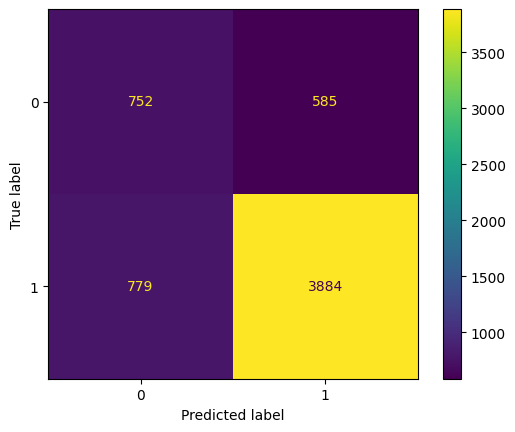

In [34]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X_train_sc, y_train)
y_pred_log = log_model.predict(X_test_sc)
y_pred_train = log_model.predict(X_train_sc)
res(y_pred_log, y_pred_train)

f1_score = 0.82930137915442
              precision    recall  f1-score   support

           0       0.45      0.61      0.52      1337
           1       0.88      0.79      0.83      4663

    accuracy                           0.75      6000
   macro avg       0.66      0.70      0.68      6000
weighted avg       0.78      0.75      0.76      6000

train_accuracy: 0.752
test_accuracy: 0.7483333333333333


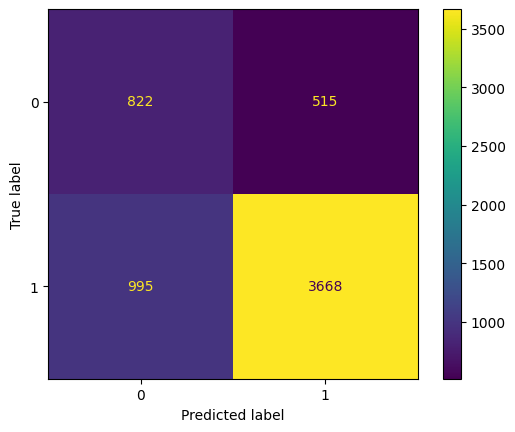

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=70, max_depth=5, min_samples_leaf=4, min_samples_split=3, class_weight='balanced'
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
y_pred_rf_train = rf_model.predict(X_train_sc)
res(y_pred_rf, y_pred_rf_train)


LIMIT_BAL: 0.0378
PAY_1: 0.2700
PAY_2: 0.1268
PAY_3: 0.0510
PAY_4: 0.0608
PAY_5: 0.0419
PAY_6: 0.0178
PAY_BILL_RATIO1: 0.0479
PAY_BILL_RATIO2: 0.0372
defaulting_frequency: 0.3008
Customer_demographics: 0.0081


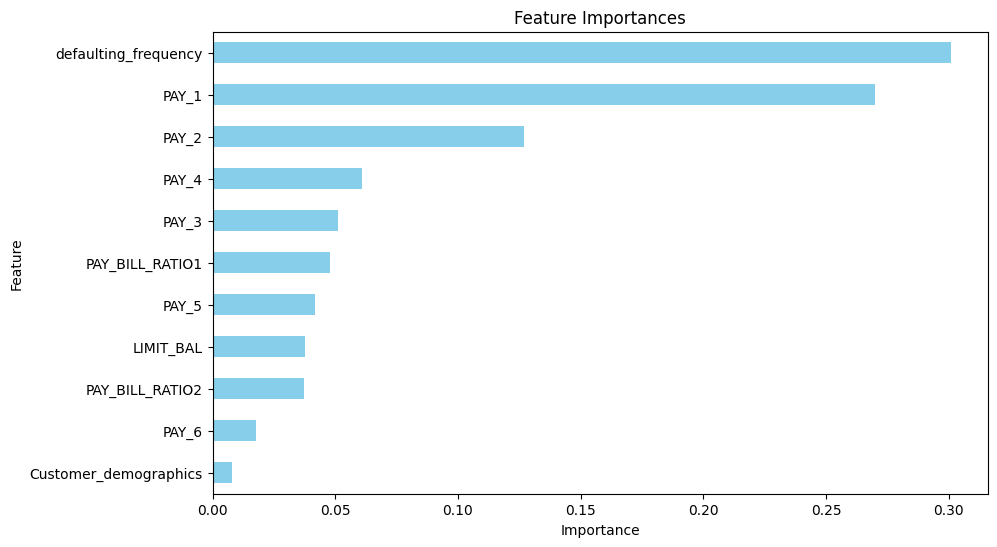

In [36]:
importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Remove the ID
# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [37]:
df_filtered.head()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,def_pay,PAY_BILL_RATIO1,PAY_BILL_RATIO2,defaulting_frequency,Customer_demographics
0,20000.0,0,0,3,3,3,3,0,0.116917,0.000000,2,0.715919
1,120000.0,3,0,3,3,3,0,0,0.014136,0.019411,2,0.715919
2,90000.0,3,3,3,3,3,3,1,0.195581,0.140104,0,-0.130488
3,50000.0,3,3,3,3,3,3,1,0.928633,0.557673,0,-0.130488
4,50000.0,3,3,3,3,3,3,1,0.009607,0.325660,0,-1.400100


In [38]:
# Splitting into dependant and independant variables
X = df_filtered.drop("def_pay", axis=1)
y = df_filtered["def_pay"]

In [39]:
# Identify important features
# important_features = [
#     feature for feature, importance in zip(X.columns, importances) if importance > 0.0
# ]
important_features = [
    feature for feature, importance in zip(X.columns, importances) if importance > 0.06
]

X_transformed_df = X

In [40]:
important_features

['PAY_1', 'PAY_2', 'PAY_4', 'defaulting_frequency']

LIMIT_BAL: 0.0378
PAY_1: 0.2700
PAY_2: 0.1268
PAY_3: 0.0510
PAY_4: 0.0608
PAY_5: 0.0419
PAY_6: 0.0178
PAY_BILL_RATIO1: 0.0479
PAY_BILL_RATIO2: 0.0372
defaulting_frequency: 0.3008
Customer_demographics: 0.0081


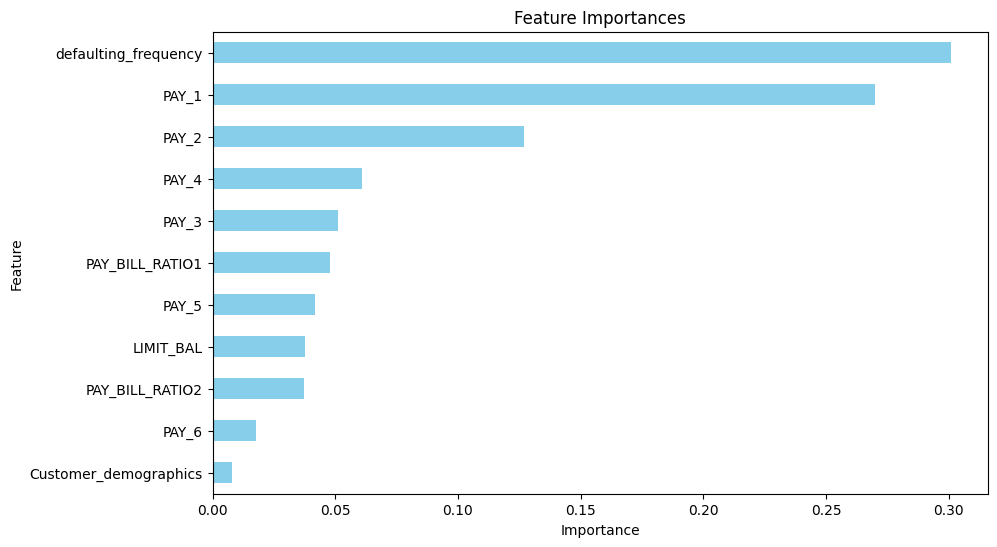

In [41]:
importances = rf_model.feature_importances_

# Loop through feature names and their corresponding importance values
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Create a DataFrame for easy plotting
importances_df = pd.Series(importances, index=X_train.columns)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importances_df.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [42]:
important_features

['PAY_1', 'PAY_2', 'PAY_4', 'defaulting_frequency']

Previous shapes: (24000, 4), (24000,)
Resampled Shape: (31788, 4), (31788,)
def_pay
1    58.824085
0    41.175915
Name: count, dtype: float64


<Axes: xlabel='def_pay', ylabel='Count'>

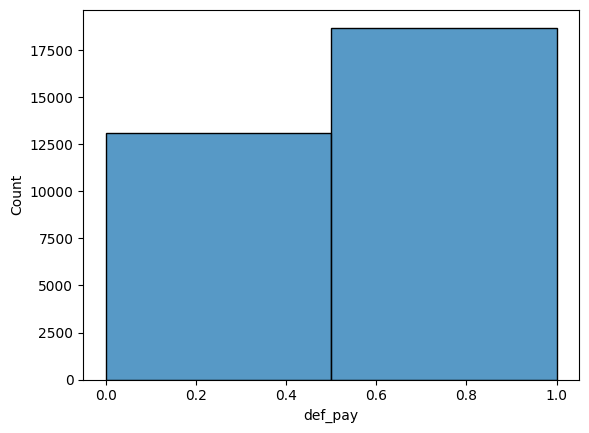

In [43]:
# FURTHER REFINING THE DATASET BASED ON THE FEATURE IMPORTANCES (REDUCED DIMENSIONALITY AND COLUMNS)
# OBJECTIVE HERE IS TO SEE IF UPSAMPLING THE DATA WOULD BE BENEFICIAL FOR THE END RESULT OR NOT 
# (This test is necessary since the data has a very high variance, which may introduce noise upon upsampling)

# Creating global x_test
X_train_glob, X_test, y_train_glob, y_test = train_test_split(
    X_transformed_df[important_features], y, test_size=0.2, random_state=2
)

# Now handle imbalance in data using SMOTE only for the important features
# SMOTEEN
smote = SMOTE(sampling_strategy=0.7, random_state=2)
# smote with tomek links

X_train_glob = sc.fit_transform(X_train_glob)
X_test = sc.fit_transform(X_test)

X_resampled, y_resampled = smote.fit_resample(X_train_glob, y_train_glob)

# New shape:
print(f"Previous shapes: {X_train_glob.shape}, {y_train_glob.shape}")
print(f"Resampled Shape: {X_resampled.shape}, {y_resampled.shape}")

print((y_resampled.value_counts() / y_resampled.shape) * 100)
sns.histplot(y_resampled, bins=2)

In [44]:
from collections import Counter

class_counts = Counter(y_train)  # Example: {0: 9500, 1: 500}
total_samples = len(y_train)
num_classes = len(class_counts)
class_weights1 = {
    cls: total_samples / (num_classes * count) for cls, count in class_counts.items()
}
class_weights1='balanced'

In [45]:
# Now doing a final training with multiple models to see which model performs the best. 
# The validation and training data have been created from the above global X_train and y_train.
# The models hyperparameters to be decided on f1 (we need the maximum f1 score here)
# Best model weights would be tested on the non-sampled x_test variable defined before.

In [46]:
from lightgbm import LGBMClassifier as lgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.utils import class_weight


results = {}

# Splitting dataset into training and validation sets (modify as per your dataset)
# Assuming X_resampled and y_resampled are your features and target labels after balancing
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=2
)

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)


scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # for XGB

# Define models to test
models = {
    "LightGBM": lgb(verbose=-1, n_jobs=-1, is_unbalance=True),
    "Logistic Regression": LogisticRegression(class_weight=class_weights1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1, class_weight=class_weights1),
    "Gradient Boosting": GradientBoostingClassifier(),  # No explicit `n_jobs`
    "XGBoost": XGBClassifier(n_jobs=-1, scale_pos_weight=scale_pos_weight),
}

# Define parameter distributions
param_distributions = {
    "Random Forest": {
        "n_estimators": randint(100, 500),
        "max_depth": [None, 10, 20],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "bootstrap": [True, False],
    },
    "Logistic Regression": {
        "C": uniform(0.01, 100),
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
        "max_iter": [100, 200],
    },
    "Gradient Boosting": {
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "min_samples_split": randint(2, 10),
    },
    "XGBoost": {  # Add XGBoost parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),
        "min_child_weight": randint(1, 10),
    },
    "LightGBM": {  # Add LightGBM parameters
        "n_estimators": randint(100, 500),
        "learning_rate": uniform(0.01, 0.3),
        "max_depth": randint(3, 7),
        "num_leaves": randint(20, 100),
        "subsample": uniform(0.5, 0.5),  # Ensures values between 0.5 and 1.0
        "colsample_bytree": uniform(0.5, 1.0),  # Ensures values between 0.5 and 1.0
    },
}


# Running RandomizedSearchCV for all models
# Fix: Set class weights only for models that support it
for model_name, model in models.items():
    print(f"Running RandomizedSearchCV for {model_name}...")

    if hasattr(model, "class_weight") and "class_weight" in model.get_params():
        print("Setting class weights...")
        model.set_params(class_weight=dict(enumerate(class_weights)))

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[model_name],
        n_iter=5,  # Number of random combinations to try
        cv=5,  # 5-fold cross-validation
        n_jobs=-1,  # Set to 1 (for single-core) or -1 (for multi-core parallelism)
        verbose=1,
        scoring="f1",
        # scoring="roc_auc",
        # scoring="accuracy",
        random_state=2,  # Ensure reproducibility
    )

    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {model_name}: {best_params}")

    # Predictions
    y_pred = best_model.predict(X_val)
    y_pred_prob = best_model.predict_proba(X_val)[
        :, 1
    ]  # Probabilities for ROC AUC and Log-Loss
    test_y_pred = best_model.predict(X_test)
    test_y_pred_prob = best_model.predict_proba(X_test)[
        :, 1
    ]  # Probabilities for ROC AUC and Log-Loss

    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    log_loss_score = log_loss(y_val, y_pred_prob)
    
    test_accuracy = accuracy_score(y_test, test_y_pred)
    test_precision = precision_score(y_test, test_y_pred)
    test_recall = recall_score(y_test, test_y_pred)
    test_f1 = f1_score(y_test, test_y_pred)
    test_roc_auc = roc_auc_score(y_test, test_y_pred_prob)
    test_log_loss_score = log_loss(y_test, test_y_pred_prob)

    # Store results
    results[model_name] = {
        "accuracy": test_accuracy,
        "precision": test_precision,
        "recall": test_recall,
        "f1_score": test_f1,
        "roc_auc": test_roc_auc,
        "log_loss": test_log_loss_score,
        "best_params": best_params,
    }

    # Print results for the model
    print(f"{model_name} - Accuracy: {accuracy:.4f}")
    print(f"{model_name} - Precision: {precision:.4f}")
    print(f"{model_name} - Recall: {recall:.4f}")
    print(f"{model_name} - F1-Score: {f1:.4f}")
    print(f"{model_name} - ROC AUC: {roc_auc:.4f}")
    print(f"{model_name} - Log Loss: {log_loss_score:.4f}")
    print(
        f"{model_name} - Classification Report:\n{classification_report(y_val, y_pred)}"
    )
    
    
    print(f"{model_name} - TEST Confusion Matrix:\n{confusion_matrix(y_test, test_y_pred)}\n")
    print(f"{model_name} - TEST Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} - TEST Precision: {test_precision:.4f}")
    print(f"{model_name} - TEST Recall: {test_recall:.4f}")
    print(f"{model_name} - TEST F1-Score: {test_f1:.4f}")
    print(f"{model_name} - TEST ROC AUC: {test_roc_auc:.4f}")
    print(f"{model_name} - TEST Log Loss: {test_log_loss_score:.4f}")
    print(
        f"{model_name} - Classification Report:\n{classification_report(y_test, test_y_pred)}"
    )
    print(f"{model_name} - Confusion Matrix:\n{confusion_matrix(y_test, test_y_pred)}\n")

Running RandomizedSearchCV for LightGBM...
Setting class weights...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for LightGBM: {'colsample_bytree': 0.9359949021420038, 'learning_rate': 0.017777869548367402, 'max_depth': 5, 'n_estimators': 399, 'num_leaves': 95, 'subsample': 0.7101839010437445}
LightGBM - Accuracy: 0.7062
LightGBM - Precision: 0.7505
LightGBM - Recall: 0.7529
LightGBM - F1-Score: 0.7517
LightGBM - ROC AUC: 0.7233
LightGBM - Log Loss: 0.6308
LightGBM - Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      3904
           1       0.75      0.75      0.75      5633

    accuracy                           0.71      9537
   macro avg       0.70      0.70      0.70      9537
weighted avg       0.71      0.71      0.71      9537

LightGBM - TEST Confusion Matrix:
[[ 885  450]
 [1186 3479]]

LightGBM - TEST Accuracy: 0.7273
LightGBM - TEST Precision: 0.8855
LightGBM - TEST Re

In [47]:
# After all models are trained, you can print the best performing model
best_model_name = max(results, key=lambda model_name: results[model_name]["f1_score"])
best_model = results[best_model_name]
print(
    f"The best performing model is {best_model_name} with an f1_score of {best_model['f1_score']:.4f}"
)

# Use the best model on the test set
print(f"Evaluating the best model ({best_model_name}) on the test set...")

# Best model selected from RandomizedSearchCV
final_model = results[best_model_name]["best_params"]

# Predictions on test data
y_test_pred = random_search.best_estimator_.predict(X_test)
y_test_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate metrics on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred)
test_confusion_mat = confusion_matrix(y_test, y_test_pred)

# Print final metrics
print("Final Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)

The best performing model is XGBoost with an f1_score of 0.8685
Evaluating the best model (XGBoost) on the test set...
Final Test Metrics:
Accuracy: 0.7915
Precision: 0.8521
Recall: 0.8855
F1-Score: 0.8685
ROC AUC: 0.7270
Log Loss: 0.5555
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.46      0.50      1335
           1       0.85      0.89      0.87      4665

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000

Confusion Matrix:
 [[ 618  717]
 [ 534 4131]]


In [48]:
# After all models are trained, you can print the best performing model
# best_model_name = max(results, key=lambda model_name: results[model_name]["f1_score"])
best_model_name = "XGBoost"
best_model = results[best_model_name]
print(
    f"The model is {best_model_name}"
)

# Use the best model on the test set
print(f"Evaluating the best model ({best_model_name}) on the test set...")

# Get the best model from RandomizedSearchCV
final_model = random_search.best_estimator_

# Predictions on test data
y_test_pred = final_model.predict(X_test)
y_test_pred_prob = final_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred)
test_confusion_mat = confusion_matrix(y_test, y_test_pred)

# Print final metrics
print("Final Test Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)

The model is XGBoost
Evaluating the best model (XGBoost) on the test set...
Final Test Metrics:
Accuracy: 0.7915
Precision: 0.8521
Recall: 0.8855
F1-Score: 0.8685
ROC AUC: 0.7270
Log Loss: 0.5555
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.46      0.50      1335
           1       0.85      0.89      0.87      4665

    accuracy                           0.79      6000
   macro avg       0.69      0.67      0.68      6000
weighted avg       0.78      0.79      0.79      6000

Confusion Matrix:
 [[ 618  717]
 [ 534 4131]]


In [49]:
# Set the threshold (you can experiment with different values, such as 0.3, 0.4, or 0.5)
threshold = (0.37)  # Example threshold for an imbalanced dataset (adjust based on tuning)

# Convert predicted probabilities to binary predictions based on the new threshold
y_test_pred_adjusted = (y_test_pred_prob >= threshold).astype(int)

# Calculate metrics with the adjusted threshold
test_accuracy = accuracy_score(y_test, y_test_pred_adjusted)
test_precision = precision_score(y_test, y_test_pred_adjusted)
test_recall = recall_score(y_test, y_test_pred_adjusted)
test_f1 = f1_score(y_test, y_test_pred_adjusted)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

# Classification report and confusion matrix
test_classification_rep = classification_report(y_test, y_test_pred_adjusted)
test_confusion_mat = confusion_matrix(y_test, y_test_pred_adjusted)

# Print final metrics
print("Final Test Metrics with threshold =", threshold)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Log Loss: {test_log_loss:.4f}")
print("Classification Report:\n", test_classification_rep)
print("Confusion Matrix:\n", test_confusion_mat)


Final Test Metrics with threshold = 0.37
Accuracy: 0.7985
Precision: 0.8501
Recall: 0.8995
F1-Score: 0.8741
ROC AUC: 0.7270
Log Loss: 0.5555
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.45      0.50      1335
           1       0.85      0.90      0.87      4665

    accuracy                           0.80      6000
   macro avg       0.70      0.67      0.69      6000
weighted avg       0.79      0.80      0.79      6000

Confusion Matrix:
 [[ 595  740]
 [ 469 4196]]


f1_score = 0.8482231816672202
              precision    recall  f1-score   support

           0       0.49      0.60      0.54      1335
           1       0.88      0.82      0.85      4665

    accuracy                           0.77      6000
   macro avg       0.68      0.71      0.69      6000
weighted avg       0.79      0.77      0.78      6000

train_accuracy: 0.7237876949350591
test_accuracy: 0.7715


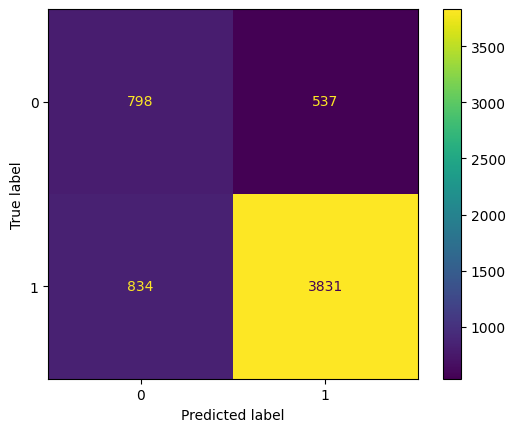

In [50]:
rf_model_smote = RandomForestClassifier(
    n_estimators=70,
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=3,
    random_state=1,
)
rf_model_smote.fit(X_train, y_train)
y_pred_rf_smote = rf_model_smote.predict(X_test)
y_pred_rf_smote_train = rf_model_smote.predict(X_train)

res(y_pred_rf_smote, y_pred_rf_smote_train)

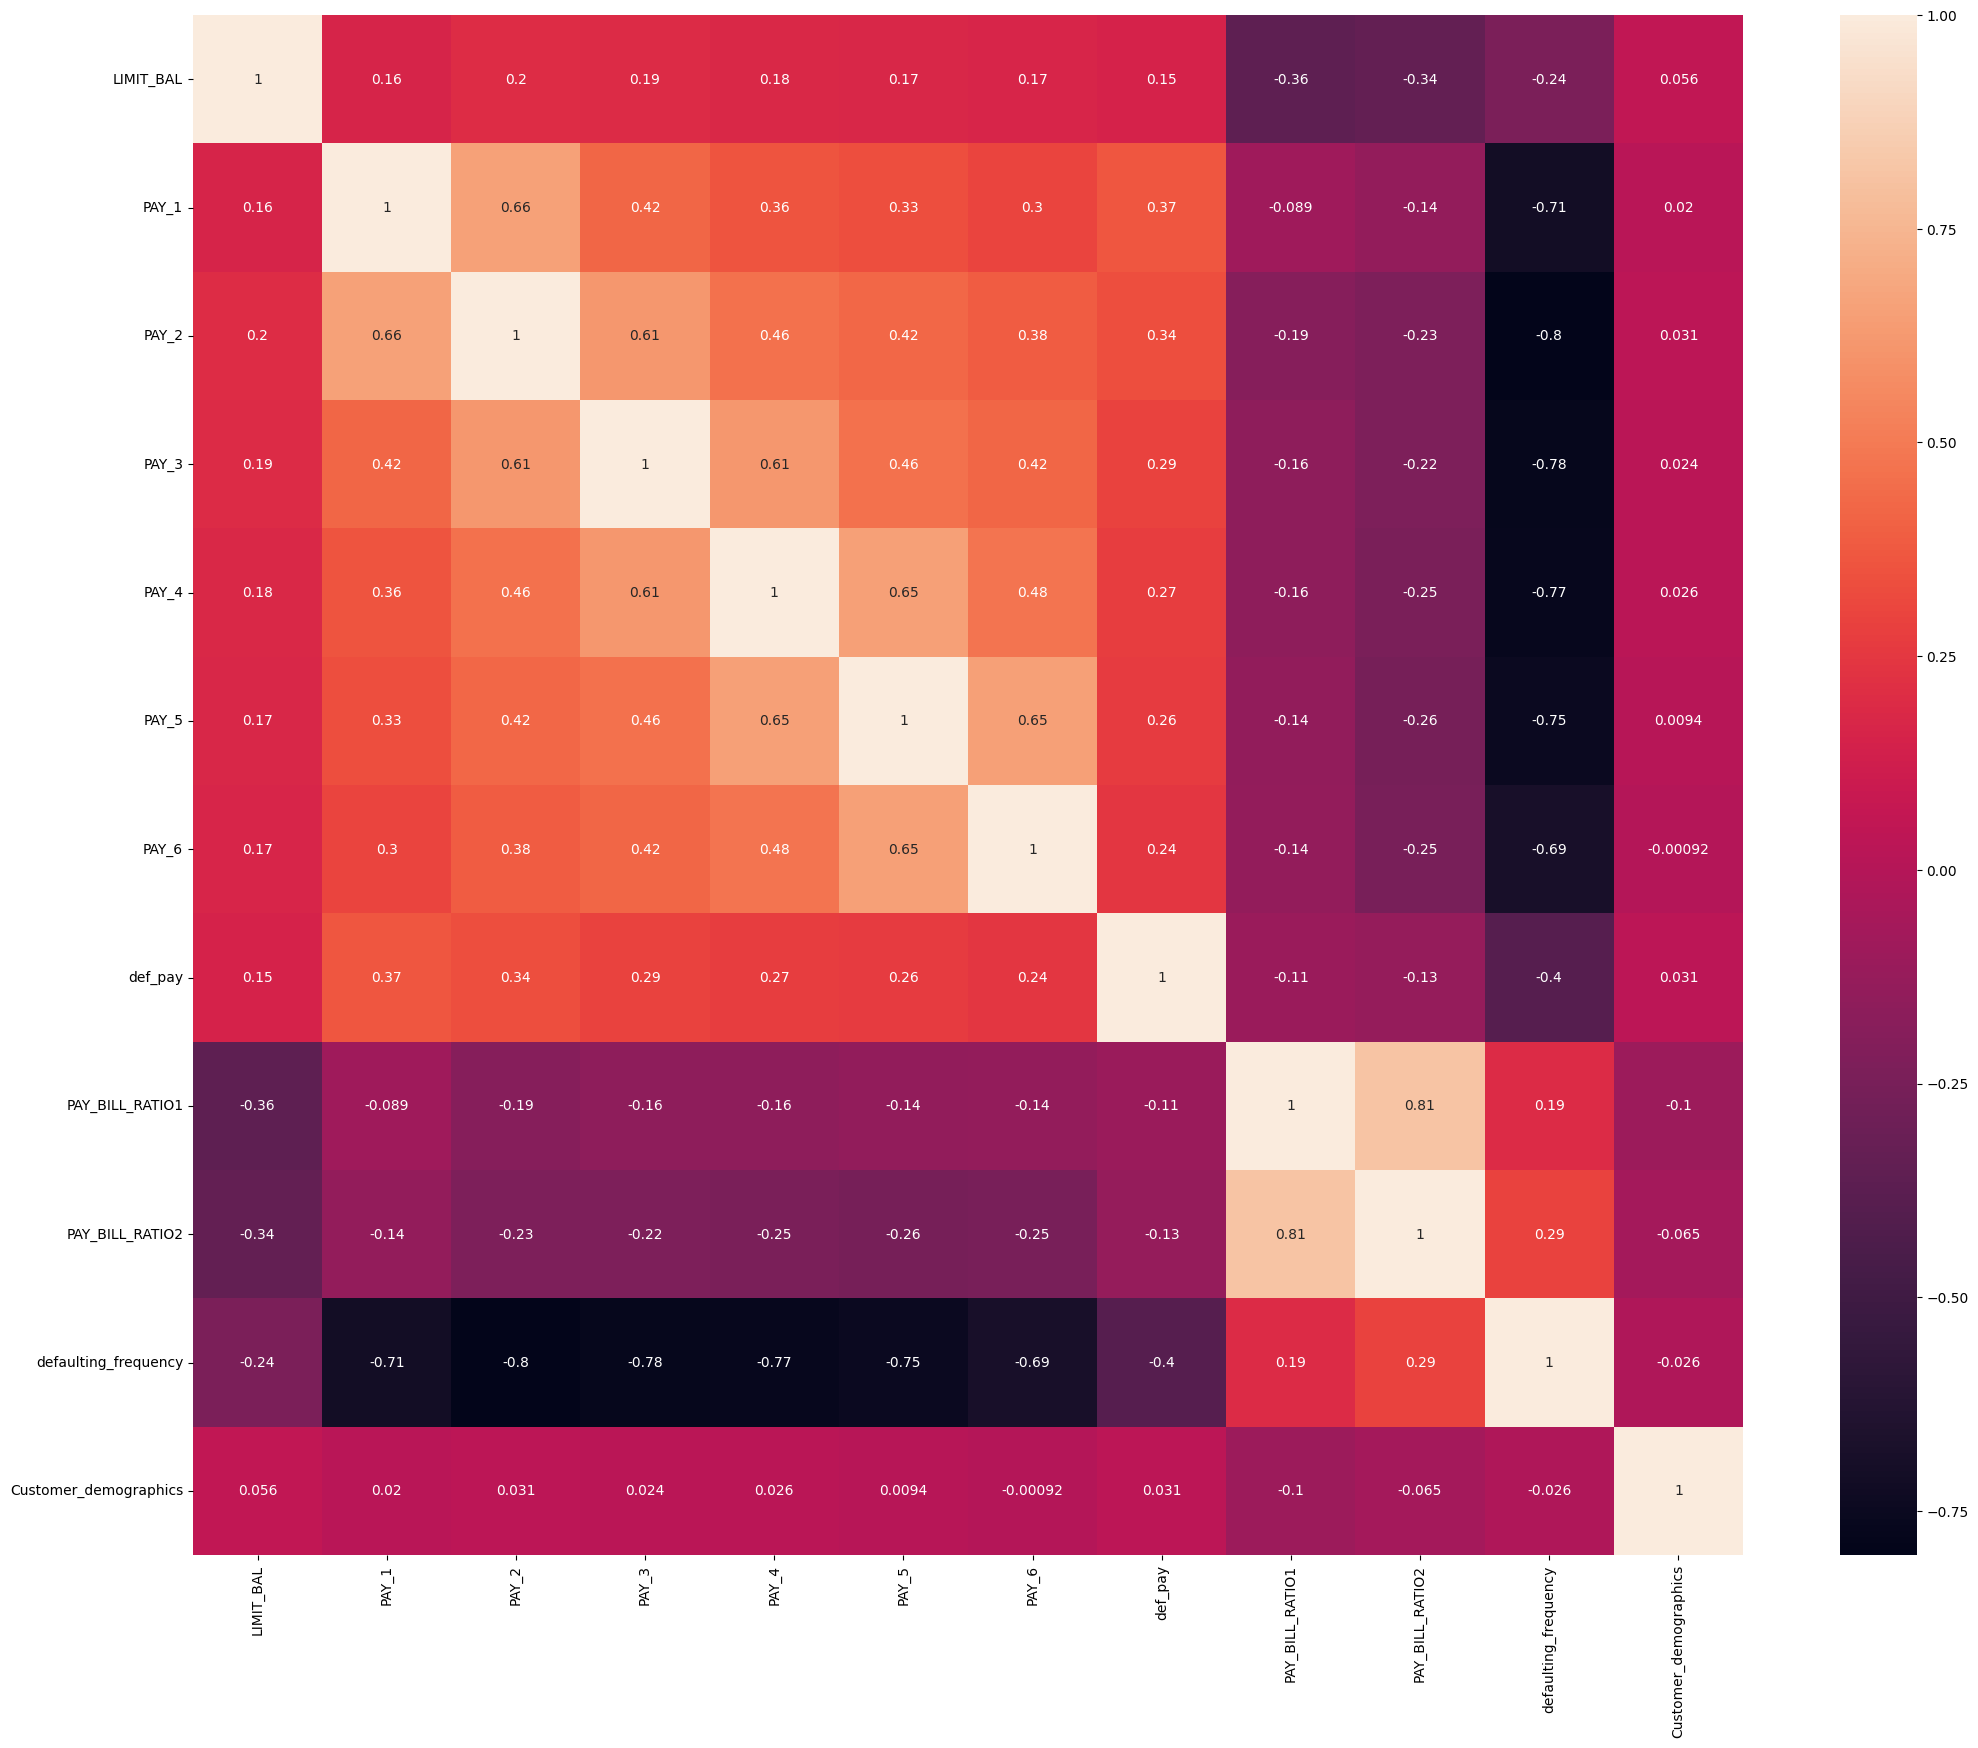

In [51]:
# Checking correlation
plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), annot=True)
plt.show()